In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
import numpy as np
import os

In [6]:
IMAGE_SHAPE = (128, 128, 3)
CLASS_ONE = "Mundo1"

TRAIN_DATA_FILES = ["./DataNous/Caso12/Entrenamiento/Mundo1/*.png", "./DataNous/Caso12/Entrenamiento/Mundo2/*.png"]
VALIDATION_DATA_FILES = ["./DataNous/Caso12/Validacion/Mundo1/*.png", "./DataNous/Caso12/Validacion/Mundo2/*.png"]

CHECKPOINTS = "./DataNous/Caso_Facil/Checkpoints/Caso12_{epoch:04d}.h5"

BATCH_SIZE = 32

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), strides=(2,2), padding='same', input_shape=IMAGE_SHAPE))
model.add(tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), padding='same'))
model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16385     
Total params: 39,969
Trainable params: 39,969
Non-trainable params: 0
_________________________________________________________________


In [4]:
def process_dataset(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    label = label == CLASS_ONE
    label = tf.cast(label, dtype=tf.float32)

    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image)
    image = tf.image.resize(image, (128, 128))
    image = (tf.image.convert_image_dtype(image, tf.float32) / 127.5) - 1

    return image, label

In [7]:
train_dataset = tf.data.Dataset.list_files(TRAIN_DATA_FILES)
train_dataset = train_dataset.map(process_dataset, tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.list_files(VALIDATION_DATA_FILES)
validation_dataset = validation_dataset.map(process_dataset, tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
Optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
Loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=Optimizer,
               loss=Loss,
               metrics=['binary_accuracy'])

checkpoints = tf.keras.callbacks.ModelCheckpoint(CHECKPOINTS,
                                                 save_best_only=True,
                                                 monitor='binary_accuracy')

In [9]:
initial_epochs = 20
num_batches = np.ceil(len(list(tf.data.Dataset.list_files(TRAIN_DATA_FILES))) / BATCH_SIZE)
num_batches

384.0

In [10]:
history = model.fit(x=train_dataset,
                       shuffle=True,
                       #verbose=2,
                       callbacks=[checkpoints], #, TensorBoard],
                       steps_per_epoch=num_batches,
                       epochs=initial_epochs,
                       validation_data=validation_dataset,
                       initial_epoch=0)

Train for 384.0 steps, validate for 43 steps
Epoch 1/20
384/384 [==============================] - 116s 302ms/step - loss: 1.2665 - binary_accuracy: 0.4969 - val_loss: 0.8747 - val_binary_accuracy: 0.5125
Epoch 2/20
384/384 [==============================] - 101s 262ms/step - loss: 0.8520 - binary_accuracy: 0.5515 - val_loss: 0.8036 - val_binary_accuracy: 0.5843
Epoch 3/20
384/384 [==============================] - 99s 258ms/step - loss: 0.7760 - binary_accuracy: 0.5988 - val_loss: 0.7374 - val_binary_accuracy: 0.6342
Epoch 4/20
384/384 [==============================] - 99s 259ms/step - loss: 0.7021 - binary_accuracy: 0.6335 - val_loss: 0.6754 - val_binary_accuracy: 0.6642
Epoch 5/20
384/384 [==============================] - 98s 254ms/step - loss: 0.6398 - binary_accuracy: 0.6601 - val_loss: 0.6076 - val_binary_accuracy: 0.6884
Epoch 6/20
384/384 [==============================] - 100s 261ms/step - loss: 0.5849 - binary_accuracy: 0.6898 - val_loss: 0.5440 - val_binary_accuracy: 0.712

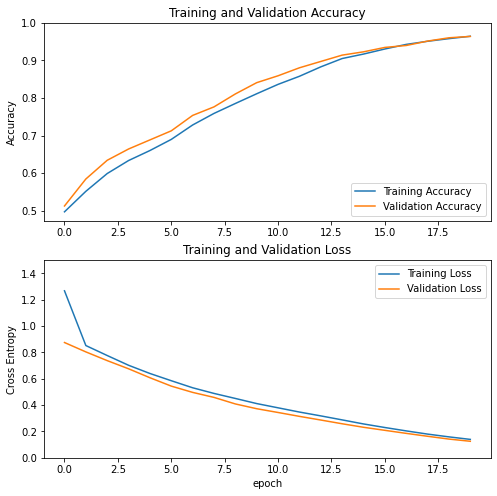

In [12]:
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()